In [3]:
import tensorflow as tf 
from tensorflow.keras import models, layers 
import matplotlib.pyplot as plt
import numpy as np

In [4]:
IMAGE_SIZE = 256 
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [5]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
   "PlantVillage",
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [6]:
class_names = dataset.class_names #folder names 

In [7]:
len(dataset) #every element in the dataset is batch of 32 elements! 

68

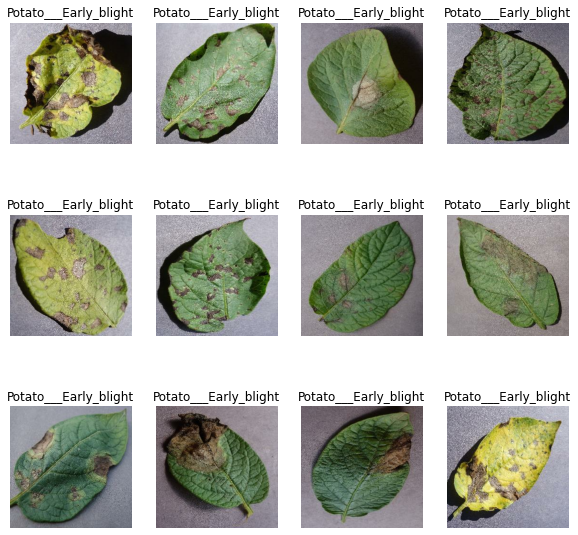

In [8]:
plt.figure(figsize= (10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.axis("off")
        plt.title(class_names[label_batch[0]])
    #print(label_batch.numpy()) #every element is a tensor so you convert to a numpy array! 
    

In [9]:
''' 
80% -> training data; 
10% -> Validation; 
10% -> Test data; 

Validation set will be used to run during testing process. After running each epoch, we use validation dataset to check/validate. 
Once we have the final model, we use the 10% test dataset to finalise the model before deploying to ensure high level performance. 
'''

' \n80% -> training data; \n10% -> Validation; \n10% -> Test data; \n\nValidation set will be used to run during testing process. After running each epoch, we use validation dataset to check/validate. \nOnce we have the final model, we use the 10% test dataset to finalise the model before deploying to ensure high level performance. \n'

In [10]:
train_size = 0.8 
len(dataset)*train_size

54.400000000000006

In [11]:
train_ds = dataset.take(54) #80% of the dataset; 

In [12]:
test_ds = dataset.skip(54) #takes the items after the 54th item. 

In [13]:
val_size = 0.1 
val_ds = test_ds.take(6)
test_ds = test_ds.skip(6)

In [14]:
def get_dataset_parameters(ds, train_split = 0.8, val_split = 0.1, test_dplit = 0.1, shuffle_size = 10000):
    
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 12)
        
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    return train_ds, val_ds, test_ds 

## Optimisation of the training data: 

In [15]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [16]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE), 
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [17]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
]) 

In [18]:
#Making the Deep learning model using CNN Algorithm :

input_shape = (BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE, CHANNELS)
n_classes = 3 
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3),activation = 'relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size = (3,3),activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size = (3,3), activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,(3,3),activation = 'relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(n_classes, activation = 'softmax'), #normalisation of probability of the classes that are present in the dataset. 
    ])

model.build(input_shape = input_shape)

In [19]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (32, 256, 256, 3)         0         
_________________________________________________________________
sequential_1 (Sequential)    (32, 256, 256, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (32, 254, 254, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (32, 127, 127, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (32, 125, 125, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (32, 62, 62, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (32, 60, 60, 64)         

In [20]:
model.compile(
    optimizer = "adam",
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits  = False),
    metrics = ['accuracy'] 
)


In [ ]:
history = model.fit(
    train_ds, 
    epochs = EPOCHS, 
    batch_size = BATCH_SIZE, 
    verbose = 1, 
    validation_data = val_ds
)


Epoch 1/50
54/54 [==============================] - 164s 3s/step - loss: 0.8975 - accuracy: 0.4757 - val_loss: 0.8885 - val_accuracy: 0.4688
Epoch 2/50
38/54 [====================>.........] - ETA: 56s - loss: 0.7356 - accuracy: 0.6546 

In [ ]:
scores = model.evaluate(test_ds)

In [ ]:
history

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

In [ ]:
plt.figure(figsize = (8,8))
plt.subplt(1,2,1)
plt.plot(range(EPOCHS), acc, label = "Training Accuracy")
plt.plot(range(EPOCHS),vall_acc, label = "Validation Accuracy")
plt.legend(loc="lower right")
plt.title("Training and Validation Accuracy")

In [ ]:
for images_batch, labels_batch in test_ds.take(1):
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0]
    
    print("First image to predict : ")
    plt.imshow(first_image)
    print("The first image's actual label : ",class_names[first_label])
    batch_prediction = model.predict(images_batch)
    print("Prediction : ",class_names[np.argmax(batch_prediction[0])])

In [ ]:
def predict(model, img):
    
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence 



In [ ]:
plt.figure(figsize = (15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype('uint8'))
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        plt.title(f"Actual :{actual_class}, \n Predicted : {predicted_class}")
        plt.axis("off")

In [ ]:
model_version = 1
model.save("C:\Code\potato-disease\models")